In [1]:
import sqlite3
from pathlib import Path
import pandas as pd
import logging
import shutil
import cv2
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', None)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [8]:
def get_balanced_face_samples():
    import sqlite3
    import pandas as pd
    from pathlib import Path
    from datetime import datetime
    import logging

    conn = sqlite3.connect('/home/nele_pauline_suffo/outputs/detection_pipeline_results/detection_results.db')
    df = pd.read_sql_query("""
    WITH RankedFaces AS (
        SELECT 
            v.video_id,
            v.video_path,
            d.frame_number,
            d.confidence_score,
            d.proximity,
            d.object_class,
            d.x_min,
            d.y_min, 
            d.x_max,
            d.y_max,
            CAST(d.proximity * 10 AS INTEGER) AS proximity_bin
        FROM Detections d
        JOIN Videos v ON d.video_id = v.video_id
        WHERE d.object_class IN (2, 3)
            AND d.proximity BETWEEN 0 AND 1
    ),
    PerVideoSamples AS (
        SELECT *,
            ROW_NUMBER() OVER (
                PARTITION BY 
                    object_class,
                    proximity_bin,
                    video_id
                ORDER BY RANDOM()
            ) AS rn_per_video
        FROM RankedFaces
    ),
    DiverseSamples AS (
        SELECT *,
            ROW_NUMBER() OVER (
                PARTITION BY object_class, proximity_bin
                ORDER BY RANDOM()
            ) AS rn_total
        FROM PerVideoSamples
        WHERE rn_per_video = 1  -- Only one sample per video per bin per class
    )
    SELECT 
        '/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed/' || video_path || '/' || 
        video_path || '_' || printf('%06d', frame_number) || '.jpg' AS frame_file_name,
        video_id,
        confidence_score,
        proximity,
        proximity_bin,
        x_min,
        y_min,
        x_max,
        y_max,
        CASE 
            WHEN object_class = 3 THEN 'adult' 
            WHEN object_class = 2 THEN 'child' 
        END AS age_group,
        CAST(proximity_bin/10.0 AS TEXT) || '-' || CAST((proximity_bin + 1)/10.0 AS TEXT) AS proximity_range
    FROM DiverseSamples
    WHERE rn_total <= 10  -- Get max 10 per bin per class
    ORDER BY age_group, proximity_bin, video_id;
    """, conn)
    
    # Log summary statistics
    summary_df = df.groupby(['age_group', 'proximity_range']).agg({
        'frame_file_name': 'count'
    }).reset_index()
    summary_df.columns = ['Age Group', 'Proximity Range', 'Total Samples']
    
    logging.info("\nSummary per bin:")
    logging.info(summary_df.to_string())
    
    # Save to CSV with bounding box information
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = Path(f"/home/nele_pauline_suffo/outputs/proximity_sampled_frames/proximity_samples_{current_time}.csv")
    output_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(output_path, index=False)
    
    conn.close()
    return df

def copy_face_samples(df):
    # First verify we have data
    if df.empty:
        logging.error("DataFrame is empty - no samples to copy")
        return
        
    logging.info(f"Processing {len(df)} samples")
    logging.info(f"Distribution:\n{df.groupby('age_group').size()}")
    
    # Define output directories
    base_dir = Path('/home/nele_pauline_suffo/outputs/proximity_sampled_frames')
    adult_dir = base_dir / 'adult_faces'
    child_dir = base_dir / 'child_faces'
    
    # Create directories if they don't exist
    adult_dir.mkdir(parents=True, exist_ok=True)
    child_dir.mkdir(parents=True, exist_ok=True)
    
    # Copy files for each age group
    copied_count = {'adult': 0, 'child': 0}
    error_count = {'adult': 0, 'child': 0}
    
    # Define colors for bounding boxes (BGR format)
    colors = {
        'adult': (0, 255, 0),  # Green for adult
        'child': (0, 0, 255)   # Red for child
    }
    
    # Create random orders for each age group
    for age_group in ['adult', 'child']:
        age_df = df[df['age_group'] == age_group].copy()
        # Create random order indices
        random_indices = np.random.permutation(len(age_df))
        age_df['random_prefix'] = [f"{i:03d}" for i in random_indices]
        
        target_dir = adult_dir if age_group == 'adult' else child_dir
        
        for _, row in age_df.iterrows():
            src_path = Path(row['frame_file_name'])
            
            if not src_path.exists():
                logging.warning(f"Source file not found: {src_path}")
                error_count[age_group] += 1
                continue
                
            try:
                # Read the image
                img = cv2.imread(str(src_path))
                if img is None:
                    logging.error(f"Could not read image: {src_path}")
                    error_count[age_group] += 1
                    continue
                    
                # Draw bounding box
                x1, y1, x2, y2 = int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max'])
                cv2.rectangle(img, (x1, y1), (x2, y2), colors[age_group], 2)
                
                # Create new filename with random prefix and proximity
                new_filename = f"{row['random_prefix']}_{src_path.name}"
                dst_path = target_dir / new_filename
                
                # Save the image with bounding box
                cv2.imwrite(str(dst_path), img)
                
                copied_count[age_group] += 1
                if copied_count[age_group] % 10 == 0:
                    logging.info(f"Copied {copied_count[age_group]} {age_group} face images")
                    
            except Exception as e:
                logging.error(f"Error processing {src_path}: {e}")
                error_count[age_group] += 1

    # Log final statistics
    for age_group in ['adult', 'child']:
        logging.info(f"{age_group.title()} faces - Copied: {copied_count[age_group]}, "
                    f"Errors: {error_count[age_group]}")
    
def create_empty_proximity_xlsx(df):
    """Create a single Excel file with separate sheets for adult and child faces.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the face samples data
    """
    import pandas as pd
    from pathlib import Path
    import logging

    base_dir = Path('/home/nele_pauline_suffo/outputs/proximity_sampled_frames')
    output_path = base_dir / 'proximity_samples_fill_in.xlsx'
    
    # Create Excel writer object
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        # Process each age group
        for age_group in ['adult', 'child']:
            folder_path = base_dir / f'{age_group}_faces'
            
            if not folder_path.exists():
                logging.error(f"Folder not found: {folder_path}")
                continue
                
            # Get all jpg files from the folder
            frame_files = sorted(folder_path.glob('*.jpg'))
            
            # Create DataFrame with filenames and empty proximity column
            output_df = pd.DataFrame({
                'frame_file_name': [f.name for f in frame_files],
                'proximity': ''  # empty column for manual proximity values
            })
            
            # Write to specific sheet in Excel file
            sheet_name = 'Adult Faces' if age_group == 'adult' else 'Child Faces'
            output_df.to_excel(writer, sheet_name=sheet_name, index=False)
            
            logging.info(f"Added {len(output_df)} {age_group} frames to sheet '{sheet_name}'")
    
    logging.info(f"Created Excel file at: {output_path}")

In [7]:
heuristic_df = get_balanced_face_samples()

len(heuristic_df)

2025-04-08 14:14:37,288 - INFO - 
Summary per bin:
2025-04-08 14:14:37,291 - INFO -    Age Group Proximity Range  Total Samples
0      adult         0.0-0.1             10
1      adult         0.1-0.2             10
2      adult         0.2-0.3             10
3      adult         0.3-0.4             10
4      adult         0.4-0.5             10
5      adult         0.5-0.6             10
6      adult         0.6-0.7             10
7      adult         0.7-0.8             10
8      adult         0.8-0.9             10
9      adult         0.9-1.0             10
10     adult         1.0-1.1             10
11     child         0.0-0.1             10
12     child         0.1-0.2             10
13     child         0.2-0.3             10
14     child         0.3-0.4             10
15     child         0.4-0.5             10
16     child         0.5-0.6             10
17     child         0.6-0.7             10
18     child         0.7-0.8             10
19     child         0.8-0.9        

220

In [10]:
# copy face samples to output directory
copy_face_samples(heuristic_df)

2025-04-08 14:22:59,921 - INFO - Processing 220 samples
2025-04-08 14:22:59,925 - INFO - Distribution:
age_group
adult    110
child    110
dtype: int64
2025-04-08 14:23:00,741 - INFO - Copied 10 adult face images
2025-04-08 14:23:10,831 - INFO - Copied 20 adult face images
2025-04-08 14:23:12,366 - INFO - Copied 30 adult face images
2025-04-08 14:23:13,231 - INFO - Copied 40 adult face images
2025-04-08 14:23:14,102 - INFO - Copied 50 adult face images
2025-04-08 14:23:14,852 - INFO - Copied 60 adult face images
2025-04-08 14:23:15,647 - INFO - Copied 70 adult face images
2025-04-08 14:23:16,631 - INFO - Copied 80 adult face images
2025-04-08 14:23:17,409 - INFO - Copied 90 adult face images
2025-04-08 14:23:18,213 - INFO - Copied 100 adult face images
2025-04-08 14:23:19,102 - INFO - Copied 110 adult face images
2025-04-08 14:23:19,862 - INFO - Copied 10 child face images
2025-04-08 14:23:20,748 - INFO - Copied 20 child face images
2025-04-08 14:23:21,588 - INFO - Copied 30 child face

In [11]:
# create empty proximity CSV for manual input
create_empty_proximity_xlsx(heuristic_df)

2025-04-08 14:27:19,893 - INFO - Added 110 adult frames to sheet 'Adult Faces'
2025-04-08 14:27:19,899 - INFO - Added 110 child frames to sheet 'Child Faces'
2025-04-08 14:27:19,916 - INFO - Created Excel file at: /home/nele_pauline_suffo/outputs/proximity_sampled_frames/proximity_samples_fill_in.xlsx


## Correlate the heuristic and estimation

In [ ]:
# read xlsx file with proximity values
proximity_df_adult_1 = pd.read_excel('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_samples_fill_in_1.xlsx', sheet_name="Adult Faces")
proximity_df_child_1 = pd.read_excel('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_samples_fill_in_1.xlsx', sheet_name='Child Faces')
proximity_df_adult_2 = pd.read_excel('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_samples_fill_in_2.xlsx', sheet_name="Adult Faces")
proximity_df_child_2 = pd.read_excel('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_samples_fill_in_2.xlsx', sheet_name='Child Faces')

# only keep rows that show NaN in column wrong
proximity_df_adult_clean_1 = proximity_df_adult_1[proximity_df_adult_1['wrong'].isna()]
proximity_df_child_clean_1 = proximity_df_child_1[proximity_df_child_1['wrong'].isna()]
proximity_df_adult_clean_2 = proximity_df_adult_1[proximity_df_adult_2['wrong'].isna()]
proximity_df_child_clean_2 = proximity_df_child_2[proximity_df_child_2['wrong'].isna()]

# add column type "adult" and drop column "wrong"
proximity_df_adult_clean_1 = proximity_df_adult_clean_1.drop(columns=['wrong'])
proximity_df_child_clean_1 = proximity_df_child_clean_1.drop(columns=['wrong'])
proximity_df_adult_clean_2 = proximity_df_adult_clean_2.drop(columns=['wrong'])
proximity_df_child_clean_2 = proximity_df_child_clean_2.drop(columns=['wrong'])
proximity_df_adult_clean_1['age_group'] = 'adult'
proximity_df_child_clean_1['age_group'] = 'child'
proximity_df_adult_clean_2['age_group'] = 'adult'
proximity_df_child_clean_2['age_group'] = 'child'

# combine both dataframes
proximity_df = pd.concat([proximity_df_adult_clean_1, proximity_df_child_clean_1, proximity_df_adult_clean_2, proximity_df_child_clean_2], ignore_index=True)

# remove the first four values of the frame_file_name column
proximity_df['frame_file_name'] = proximity_df['frame_file_name'].str[4:]

# remove duplicate rows based on frame_file_name
proximity_df_cleared = proximity_df.drop_duplicates(subset=['frame_file_name'])

# load csv with proximity heuristic values from csv as dataframe
proximity_df_heuristic_1 = pd.read_csv('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_samples_1.csv')[['frame_file_name', 'proximity']]
proximity_df_heuristic_2 = pd.read_csv('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_samples_2_long.csv')[['frame_file_name', 'proximity']]
proximity_df_heuristic_1['frame_file_name'] = proximity_df_heuristic_1['frame_file_name'].str.split('/').str[-1]
proximity_df_heuristic_2['frame_file_name'] = proximity_df_heuristic_2['frame_file_name'].str.split('/').str[-1]

# concatenate both dataframes
proximity_df_heuristic = pd.concat([proximity_df_heuristic_1, proximity_df_heuristic_2], ignore_index=True)

In [3]:
proximity_df_adult_1

NameError: name 'proximity_df_adult_1' is not defined

In [16]:
proximity_df_cleared.head()

,frame_file_name,proximity,age_group
0,quantex_at_home_id260123_2023_09_06_01_013290.jpg,0.87,adult
1,quantex_at_home_id262726_2023_03_26_01_021500.jpg,0.81,adult
2,quantex_at_home_id260275_2022_04_16_01_011640.jpg,0.21,adult
3,quantex_at_home_id264351_2024_11_23_03_016520.jpg,0.73,adult
4,quantex_at_home_id263284_2023_06_25_04_050240.jpg,0.91,adult


In [15]:
proximity_df_heuristic.head()

,frame_file_name,proximity
0,quantex_at_home_id263284_2023_06_25_07_000180.jpg,0.095526
1,quantex_at_home_id263880_2023_06_23_01_023310.jpg,0.092093
2,quantex_at_home_id263284_2023_06_25_09_034530.jpg,0.023349
3,quantex_at_home_id260176_2022_11_06_02_044550.jpg,0.089737
4,quantex_at_home_id260176_2022_11_13_02_041160.jpg,0.089445


In [19]:
# now add the proximity values from the heuristic dataframe to the proximity_df dataframe
proximity_eval_df = proximity_df_cleared.merge(proximity_df_heuristic, on='frame_file_name', how='left')
proximity_eval_df = proximity_eval_df.rename(columns={'frame_file_name': 'frame', 'proximity_x': 'proximity_true', 'proximity_y': 'proximity_heuristic'})
# change column order
proximity_eval_df = proximity_eval_df[['frame', 'proximity_true', 'proximity_heuristic', 'age_group']]
# drop rows with NaN values in the proximity_heuristic column
proximity_eval_df_clean = proximity_eval_df.dropna(subset=['proximity_heuristic'])
proximity_eval_df_clean.head()

,frame,proximity_true,proximity_heuristic,age_group
0,quantex_at_home_id260123_2023_09_06_01_013290.jpg,0.87,1.00,adult
1,quantex_at_home_id262726_2023_03_26_01_021500.jpg,0.81,0.29,adult
2,quantex_at_home_id260275_2022_04_16_01_011640.jpg,0.21,0.37,adult
4,quantex_at_home_id263284_2023_06_25_04_050240.jpg,0.91,0.59,adult
6,quantex_at_home_id260275_2022_04_16_01_023830.jpg,0.08,0.22,adult


Pearson Correlation: 0.8342777531800891
Spearman Correlation: 0.767646926845626


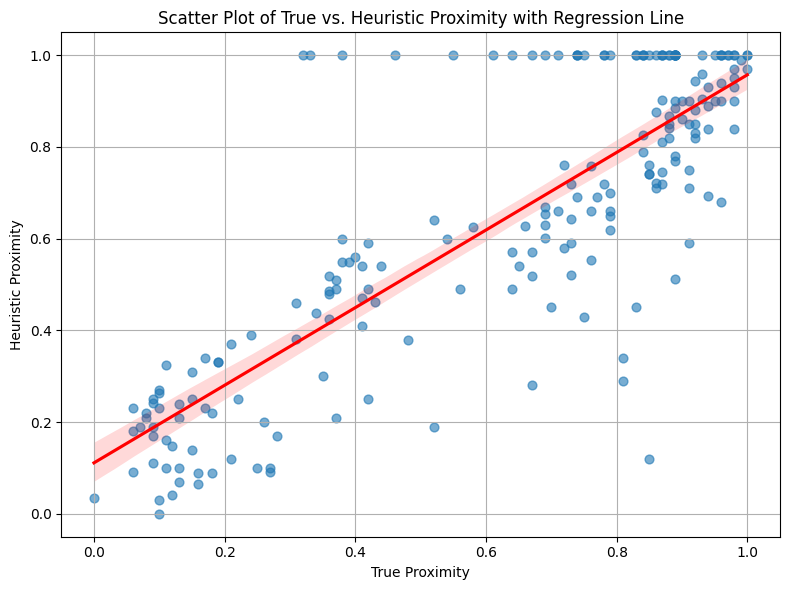

In [22]:
# Calculate Pearson Correlation Coefficient
pearson_corr = proximity_eval_df_clean['proximity_true'].corr(proximity_eval_df_clean['proximity_heuristic'])
print(f"Pearson Correlation: {pearson_corr}")

# Calculate Spearman Rank Correlation
spearman_corr = proximity_eval_df_clean['proximity_true'].corr(proximity_eval_df_clean['proximity_heuristic'], method='spearman')
print(f"Spearman Correlation: {spearman_corr}")

# Visualize with regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    x='proximity_true',
    y='proximity_heuristic',
    data=proximity_eval_df_clean,
    scatter_kws={'s': 40, 'alpha': 0.6},  # control point appearance
    line_kws={'color': 'red'},            # regression line style
)
plt.title('Scatter Plot of True vs. Heuristic Proximity with Regression Line')
plt.xlabel('True Proximity')
plt.ylabel('Heuristic Proximity')
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
check_df = proximity_eval_df_clean[proximity_eval_df_clean['proximity_heuristic']==1]

# get absolute difference between proximity_true and proximity_heuristic and sort by it
check_df['proximity_diff'] = abs(check_df['proximity_true'] - check_df['proximity_heuristic'])
check_df = check_df.sort_values(by='proximity_diff', ascending=False)

/tmp/ipykernel_135181/1161336826.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_df['proximity_diff'] = abs(check_df['proximity_true'] - check_df['proximity_heuristic'])


In [25]:
check_df

,frame,proximity_true,proximity_heuristic,age_group,proximity_diff
47,quantex_at_home_id271700_2023_03_27_01_026440.jpg,0.32,1.0,adult,0.68
179,quantex_at_home_id260478_2022_11_05_01_012300.jpg,0.33,1.0,child,0.67
145,quantex_at_home_id258239_2021_02_15_01_005870.jpg,0.38,1.0,child,0.62
36,quantex_at_home_id264351_2024_11_23_03_010000.jpg,0.46,1.0,adult,0.54
64,quantex_at_home_id271700_2023_06_16_01_011050.jpg,0.55,1.0,adult,0.45
167,quantex_at_home_id263207_2024_12_12_02_007910.jpg,0.61,1.0,adult,0.39
68,quantex_at_home_id264351_2024_11_23_03_027610.jpg,0.64,1.0,adult,0.36
177,quantex_at_home_id263204_2024_12_19_01_001700.jpg,0.67,1.0,child,0.33
118,quantex_at_home_id263207_2024_12_12_04_006860.jpg,0.69,1.0,child,0.31
129,quantex_at_home_id257511_2021_07_06_02_031810.jpg,0.71,1.0,child,0.29
